In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
plot_path=start_path+"/../plots/"
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"/src/")
sys.path.insert(4,synth_ar_path+"/plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"/plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Allocations, Switches, and Definitions

In [2]:
campaign="HALO_AC3"
ar_of_day="AR_entire_1"
flight=["RF05"]
reflectivity_for_snow="Z_e"
sector_to_plot="warm"
take_arbitary=True
do_plotting=True
calibrated_radar=True

from simplified_flight_leg_handling import simplified_run_grid_main
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
flight=cmpgn_cls.flight

flight_dates={
    "RF03":"20220313",
    "RF05":"20220315",
    "RF06":"20220316",
    "RF16":"20220410"}
#halo_era5

## reanalysis dataset (if needed load)

In [3]:
#Load config file
config_file=data_config.load_config_file(major_work_path,"data_config_file")

cmpgn_cls=flightcampaign.HALO_AC3(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               

import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
        #IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds


C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [4]:
# ICON File
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
print(hydrometeor_icon_path)
icon_resolution=2000 # units m
upsample_time="20min"
date=flight_dates[flight[0]]
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
        
icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
    cmpgn_cls,icon_var_list,halo_df,flight,date,
    interpolated_hmp_file=interp_icon_hmp_file,
    interpolated_hmc_file=None,ar_of_day=ar_of_day,
    upsample_time=upsample_time,
    synthetic_icon=False,
    synthetic_flight=False)

if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)

halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()
#halo_icon_hmp["Interp_Precip"]/=1000
halo_icon_hmp.describe()

C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/
RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened


,Minutesofday,Halo_Lat,Halo_Lon,Interp_IWV,Interp_LWP,Interp_IWP,Interp_Precip,Interp_EV
count,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,1.110000e+04,1.110000e+04,11100.000000
mean,703.000000,74.358359,-3.209102,12.484149,66.332258,3.816715e+01,6.345345e-02,0.002438
std,53.406525,1.851320,8.496497,3.025169,45.843162,3.499808e+01,1.066971e-01,0.006509
min,611.000000,71.004653,-17.905399,6.714970,2.024943,-2.672140e-16,0.000000e+00,-0.017555
25%,657.000000,72.674204,-10.425367,10.135101,26.975203,8.331337e+00,6.507131e-07,0.000281
50%,703.000000,74.668138,-3.405043,13.440480,61.005189,2.501107e+01,2.427246e-03,0.003038
75%,749.000000,75.985555,3.423181,14.990513,101.071889,7.151576e+01,8.098447e-02,0.006301
max,795.000000,77.000478,13.164154,16.628483,223.254492,1.082445e+02,4.796362e-01,0.015707


## Flight leg and AR localisation

In [5]:
if flight[0]=="RF03":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-13 10:00","2022-03-13 10:35"]
            internal_times=["2022-03-13 10:37","2022-03-13 11:10"]
            outflow_times=["2022-03-13 11:16","2022-03-13 11:40"]
    
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30 ","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20 ","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
if flight[0]=="RF16":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-04-10 10:40","2022-04-10 11:08"]
            internal_times=["2022-04-10 11:10","2022-04-10 11:36"]
            outflow_times=["2022-04-10 11:57","2022-04-10 12:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}
from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])
print(AR_inflow["AR_inflow"].keys())
relevant_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]

Index(['time', 'Minutesofday', 'Halo_Lat', 'Halo_Lon', 'Closest_Era_Lat',
       'Closest_Era_Lon', 'Interp_IWV', 'Interp_E', 'Interp_Precip',
       'Interp_LWP', 'Interp_IWP', 'Interp_IVT', 'IVT_max_distance'],
      dtype='object')
Analyse frontal sector  warm_sector
Analyse frontal sector  core
Analyse frontal sector  cold_sector


## Radar dataset

In [6]:
# processing_path packages
import data_config

import measurement_instruments_ql
#import halodataplot as Data_Plotter
import quicklook_dicts

#BAHAMAS.bahamas_ds
radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name

airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"
print(airborne_data_importer_path)

date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path

# Data Handling 
datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
# Get Plotting Handling
plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)

radar_ds=Radar_cls.open_version_specific_processed_radar_data(for_calibrated_file=calibrated_radar)

C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/
Look for Radar data in  C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/radar_20220315
C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/radar_20220315_v1*.nc
Opened specific version: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc\radar_20220315_v1.6.nc


In [7]:
# Radar data
radar_dict["dBZg"]=pd.DataFrame(data=np.array(radar_ds["dBZg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))

radar_dict["LDRg"]=pd.DataFrame(data=np.array(radar_ds["LDRg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))
if inflow_times[0]<outflow_times[-1]:
    processed_radar=radar_ds.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    processed_radar=radar_ds.sel({"time":slice(outflow_times[0],inflow_times[-1])})
processed_radar

<xarray.Dataset>
Dimensions:     (time: 11100, height: 434)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-15T10:11:00 ... 2022-03-15T13:1...
  * height      (height) float64 0.0 30.0 60.0 ... 1.293e+04 1.296e+04 1.299e+04
Data variables:
    dBZg        (time, height) float64 ...
    Zg          (time, height) float64 ...
    Ze          (time, height) float64 ...
    dBZe        (time, height) float64 ...
    LDRg        (time, height) float64 ...
    RMSg        (time, height) float64 ...
    VELg        (time, height) float64 ...
    SNRg        (time, height) float64 ...
    lat         (time) float64 ...
    lon         (time) float64 ...
    alt         (time) float64 ...
    radar_flag  (time, height) float64 ...
Attributes:
    contact:               henning.dorff@uni-hamburg.de
    flight_date:           20220315
    flight_number:         RF05
    mission:               HALO_AC3
    comment:               Preliminary Calibrated data. Still use with caution.
    performed_processing:   Entire data gap filled. Clutter removed. Side lob...

### Melting layer detection via Bright Band for Precipitation Phase

In [8]:
#def find_rough_melting_layer(radar_dict):
    
#    height=np.array(radar_dict["height"][:])
#    ldr_df=pd.DataFrame(data=np.array(radar_dict["LDRg"][:]),
#                 columns=height,
#                 index=pd.DatetimeIndex(
#                     np.array(radar_dict["time"])))
    #aircraft_df=pd.DataFrame(data=np.nan,columns=["roll","hdg","sfc","lat","lon"],
    #                  index=pd.DatetimeIndex(\
    #                     np.array(bahamas_dict[flight]["TIME"])))
    #aircraft_df["roll"]=np.array(bahamas_dict[flight]["IRS_PHI"])                             
    #aircraft_df["hdg"]=np.array(bahamas_dict[flight]["IRS_HDG"])
    #aircraft_df["lat"]=np.array(bahamas_dict[flight]["IRS_LAT"])                             
    #aircraft_df["lon"]=np.array(bahamas_dict[flight]["IRS_LON"])
    #aircraft_df=aircraft_df.resample("1s").mean()
    #mask_df=Bahamas_cls.add_surface_mask_to_data(bahamas_dict[flight],
    #                                             prcs_cfg_dict,
    #                                             resolution="10s")
    #mask_df=mask_df.resample("1s").bfill()
    #aircraft_df=aircraft_df.reindex(mask_df.index)
    #aircraft_df["sfc"]=mask_df["sea_ice"]
    #aircraft_df["sfc"]=aircraft_df["sfc"].fillna(method="bfill")

    # ldr detection
    #cutted_aircraft_df=aircraft_df[abs(aircraft_df["roll"])<5]
    #cutted_aircraft_df=cutted_aircraft_df[cutted_aircraft_df["sfc"]>=0]
#    ldr_cutted_df=ldr_df.copy()#.reindex(cutted_aircraft_df.index)

#    lower_height_thres=5
#    low_ldr_df=ldr_cutted_df.iloc[:,lower_height_thres:70]
#    low_ldr_df[low_ldr_df<-17]=np.nan
    
#    ldr_mlayer_height=low_ldr_df.idxmax(axis=1)
#    return ldr_

def find_melting_layer(radar_dict,vertical_value_to_use="max"):    
    ldr_threshold=-17
    lower_height_thres=5
    maximum_height=2000
    maximum_gradient=60
    # based on Austen et al. 2023    
    height=np.array(radar_dict["height"][:])
    ldr_df=pd.DataFrame(data=np.array(radar_dict["LDRg"][:]),
                 columns=height,
                 index=pd.DatetimeIndex(
                     np.array(radar_dict["time"])))

    ldr_cutted_df=ldr_df.copy()#.reindex(cutted_aircraft_df.index)

    low_ldr_df=ldr_cutted_df.iloc[:,lower_height_thres:70]
    #-------------------------------------------------------------------------#
    # LDR threshold
    low_ldr_df[low_ldr_df<ldr_threshold]=np.nan

    # which value to use if a vertical column is above ldr_threshold
    # my method was the maximum value which always shifts the bright band above
    # version auf Austen is 
    if vertical_value_to_use=="max":    
        ldr_mlayer_height=low_ldr_df.idxmax(axis=1)
    elif vertical_value_to_use=="lowest": # Austen et al. 2023
        #this is a bad method but performs well
        mask_of_ldr_values=low_ldr_df/low_ldr_df
        ldr_mlayer_height=mask_of_ldr_values.idxmin(axis=1)
        #for idx in low_ldr_df.index:
        #    vertical_profile=pd.Series(data=low_ldr_df.iloc[idx,:],
        #                               index=)
    
    #-------------------------------------------------------------------------#
    # LDR should always lie below maximum height defined above
    ldr_mlayer_height[ldr_mlayer_height>maximum_height]=np.nan
    
    #-------------------------------------------------------------------------#
    # Gradient criteria (continuity), it is less strong than in Austin et al.
    ldr_ml_height_gradient=ldr_mlayer_height.diff()
    strong_gradient=ldr_ml_height_gradient[\
                        abs(ldr_ml_height_gradient)>maximum_gradient]
    # set value to nan for too strong gradients
    ldr_mlayer_height.loc[strong_gradient.index]=np.nan
    #-------------------------------------------------------------------------#
    # 5s rolling mean
    ldr_mlayer_height=ldr_mlayer_height.rolling("5s",min_periods=5).mean()   
    #-------------------------------------------------------------------------#
    # Melting layer mask
    mlayer_mask=pd.Series(data=np.zeros(ldr_mlayer_height.shape[0]),
                          index=ldr_mlayer_height.index)
    mlayer_mask[~ldr_mlayer_height.isnull()]+=1
    #-------------------------------------------------------------------------#
    # max 10 s gap filling via interpolation
    ldr_mlayer_height=ldr_mlayer_height.interpolate(method="polynomial",order=5,
                                                    limit=10,limit_area="inside",
                                                    limit_direction="both")
    # Extrapolate
    ldr_mlayer_height=ldr_mlayer_height.interpolate(method="polynomial",order=5,
                                                    limit_area="outside",limit=10,
                                                    fill_value="extrapolate")
    condition_1=mlayer_mask==0
    condition_2=~ldr_mlayer_height.isnull()
    both_conditions= condition_1 & condition_2
    mlayer_mask[both_conditions]=2
    #
    mlayer_mask[ldr_mlayer_height.between(0,270,inclusive="right")]=2
    #------------------------------------------------------------------------- #
    #
    return ldr_mlayer_height,low_ldr_df,ldr_cutted_df,mlayer_mask

def classify_precipitation_type(radar_dict, bb_height,bb_mask):
    surface_Zg=radar_dict["Zg"][:,4]
    surface_Zg=surface_Zg.where(surface_Zg!=-888.)
    sfc_zg_series=pd.Series(data=np.array(surface_Zg[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Zg.time[:])))
    surface_type=pd.Series(data=np.array(radar_dict["radar_flag"].values[:,0]),
                           index=sfc_zg_series.index)
    
    precip_type_series=pd.Series(data=np.nan,
                                 index=pd.DatetimeIndex(
                                     np.array(surface_Zg.time[:])))
    precip_type_series[sfc_zg_series.isnull()]=0
    precip_type_series[~sfc_zg_series.isnull()]=1.0 # snow
    precip_type_series.loc[bb_mask==1.0]=2.0 # rain
    precip_type_series.loc[bb_mask==2.0]=3.0 # uncertain    
    precip_type_series[surface_type==-0.1]=-1.0
    # take as last conditions do not anymore look for clear rain defined signals
    # but maybe it is not important once applied to the rain reflectivities
    return precip_type_series,sfc_zg_series

## Precipitation (rain) rate Z-R/S Relationships


In [9]:
def get_rain_rate(zg_series):
    rain_rate=pd.DataFrame(data=np.nan, index=zg_series.index,
                           columns=["norris","palmer","chandra"])
    rain_rate["norris"]   = 1/466*zg_series**(1/1.47)
    rain_rate["palmer"]   = 1/200*zg_series**(1/1.6)
    rain_rate["chandra"]  = 1/177*zg_series**(1/1.11)
    rain_rate["mean_rain"]= rain_rate.mean(axis=1)
    return rain_rate

def get_snow_rate(zg_series):
    snow_rate=pd.DataFrame(data=np.nan,index=zg_series.index,
                          columns=["schoger","matrosov","heymsfield"])
    snow_rate["schoger"]   = 1/77.67*zg_series**(1/1.22)
    snow_rate["matrosov"]  = 1/56*zg_series**(1/1.2)
    snow_rate["heymsfield"]= 1/10.13*zg_series**(1/1.92)
    snow_rate["mean_snow"] = snow_rate.mean(axis=1) 
    return snow_rate

def take_correct_precipitation_rates(zg_series_dict,surface_mask,bb_mask,z_for_snow="Z_e"):
    precipitation_rate=pd.DataFrame(data=np.nan,index=zg_series.index,
                           columns=["r_norris","r_palmer","r_chandra",
                                   "s_schoger","s_matrosov","s_heymsfield",
                                   "mean_snow","mean_rain","surface","precip_phase"])
    default_rain_rate=get_rain_rate(z_series_dict["zg"])
    if z_for_snow=="Z_e":
        z_snow=z_series_dict["ze"]
    else:
        z_snow=z_series_dict["zg"]
        
    default_snow_rate=get_snow_rate(z_snow)
    #Snow rate
    precipitation_rate["s_schoger"].loc[bb_mask==1]=default_snow_rate["schoger"]
    precipitation_rate["s_matrosov"].loc[bb_mask==1]=default_snow_rate["matrosov"]
    precipitation_rate["s_heymsfield"].loc[bb_mask==1]=default_snow_rate["heymsfield"]
    precipitation_rate["mean_snow"].loc[bb_mask==1]=default_snow_rate["mean_snow"]
    #Rain rate
    precipitation_rate["r_norris"].loc[bb_mask==2]=default_rain_rate["norris"]
    precipitation_rate["r_palmer"].loc[bb_mask==2]=default_rain_rate["palmer"]
    precipitation_rate["r_chandra"].loc[bb_mask==2]=default_rain_rate["chandra"]
    precipitation_rate["mean_rain"].loc[bb_mask==2]=default_rain_rate["mean_rain"]
    precipitation_rate["surface"]=surface_mask.values
    precipitation_rate["precip_phase"].loc[bb_mask==1]="snow"
    precipitation_rate["precip_phase"].loc[bb_mask==2]="rain"
    precipitation_rate["precip_phase"].loc[bb_mask==3]="uncertain"
    precipitation_rate["precip_phase"].loc[bb_mask==-1]="land"
    return precipitation_rate

#precip_times_norris=rain_rate["norris"][2000:28000]
#precip_times_norris=precip_times_norris.where(precip_times_norris>0.0)
#precip_times_norris.mean()
#precip_times_chandra=rain_rate["chandra"][2000:28000]
#precip_times_chandra=precip_times_chandra.where(precip_times_chandra>0.0)
#print(precip_times_chandra)
#sys.exit()
#rain_rate=get_norris_rain_rate(surface_Zg)
#print(rain_rate["mean"].mean())
#sys.exit()
#reflect_fig=plt.figure(figsize=(16,9))
#ax1=reflect_fig.add_subplot(111)
#ax1.plot(rain_rate["norris"][2000:28000],label=str(round(float(),2)))
#ax1.plot(rain_rate["chandra"][2000:28000],label=str(round(float(rain_rate["chandra"][2000:28000].mean()),2)))
#ax1.set_ylim([0,2])
#ax1.legend()

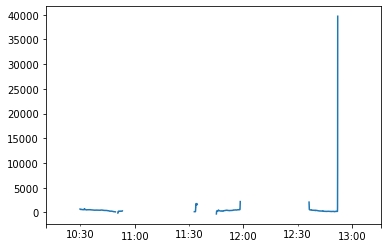

In [10]:
import halodataplot
# Radar reflectivity
processed_radar=halodataplot.replace_fill_and_missing_values_to_nan(
                                processed_radar,["dBZg","Zg","Ze",
                                                 "LDRg","VELg",
                                                 "radar_flag"])        
       
mlayer_height,low_ldr_df,ldr_cutted_df,bb_mask=find_melting_layer(processed_radar)
#    ldr_mlayer_height,low_ldr_df,ldr_cutted_df=find_melting_layer(processed_radar)
mlayer_height.plot()

In [11]:
precip_type_series,zg_series=classify_precipitation_type(processed_radar,mlayer_height,bb_mask)
surface_mask=pd.Series(data=np.array(processed_radar["radar_flag"][:,0]),
                        index=pd.DatetimeIndex(np.array(processed_radar.time[:])))
surface_mask

2022-03-15 10:11:00    5.000000
2022-03-15 10:11:01    5.000000
2022-03-15 10:11:02    5.000000
2022-03-15 10:11:03    5.000000
2022-03-15 10:11:04    5.000000
                         ...   
2022-03-15 13:15:55    0.985592
2022-03-15 13:15:56    0.985592
2022-03-15 13:15:57    0.985592
2022-03-15 13:15:58    0.985592
2022-03-15 13:15:59    0.985592
Length: 11100, dtype: float64

In [12]:
surface_Ze=processed_radar["Ze"][:,4]
surface_Ze=surface_Ze.where(surface_Ze!=-888.)
ze_series=pd.Series(data=np.array(surface_Ze[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Ze.time[:])))    
z_series_dict={}
z_series_dict["zg"]=zg_series
z_series_dict["ze"]=ze_series
precipitation_rate=take_correct_precipitation_rates(z_series_dict,surface_mask,bb_mask,z_for_snow=reflectivity_for_snow)

Plotting HAMP Cloud Radar (processed and calibrated)
flag nans
flagging done
dBZ plotted
LDR plotted
Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_Rain_internal_calibrated and processed_radar_Ze.png


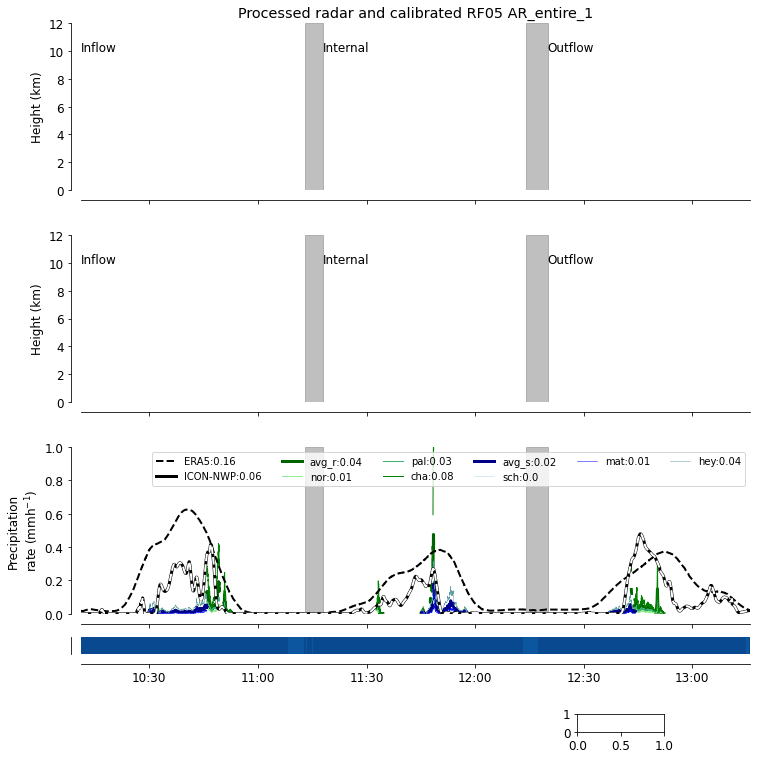

In [13]:
Radar_Plots=halodataplot.Radar_Quicklook(cfg_dict)
Radar_Plots.processed_radar=processed_radar
Radar_Plots.flight=flight
Radar_Plots.plot_path=plot_path
if do_plotting:
    radar_str=Radar_Plots.processed_radar_rain_rate(halo_era5,halo_icon_hmp,
                                  precipitation_rate,inflow_times,
                                  internal_times,outflow_times,ar_of_day,
                                  calibrated_radar=True,
                                  reflectivity_for_snow="Ze")

Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_Only_Rain_internal_calibrated and processed_radar_Ze.png


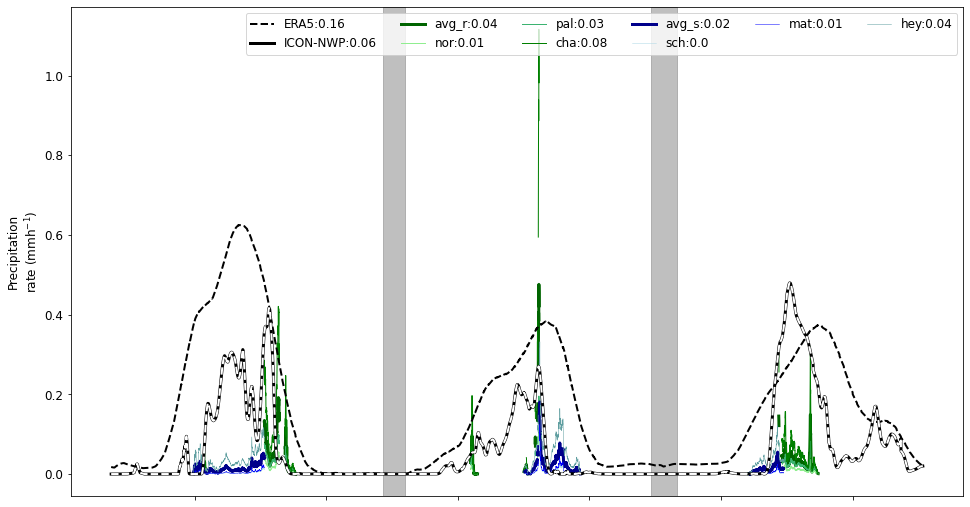

In [14]:
if do_plotting:
    Radar_Plots.plot_only_precip_rates(halo_era5,halo_icon_hmp,
                               precipitation_rate,ar_of_day,
                               inflow_times,internal_times,outflow_times,
                               radar_str,reflectivity_for_snow="Ze")

In [15]:
# load hydrometeor ICON files for precipitation
central_hour="12"
hydro_fpath=major_work_path+campaign+"/data/ICON_LEM_2km/"+flight[0]+"/"
hydro_file="Hydrometeor_ICON_"+flight[0]+"_"+ar_of_day+"_"+central_hour+"UTC.nc"
hydro_ds=xr.open_dataset(hydro_fpath+hydro_file)
hydro_ds

<xarray.Dataset>
Dimensions:      (time: 4, ncells: 329072)
Coordinates:
  * time         (time) datetime64[ns] 2022-03-15T12:00:00 ... 2022-03-15T13:...
    clon         (ncells) float32 ...
    clat         (ncells) float32 ...
Dimensions without coordinates: ncells
Data variables:
    tqv_dia      (time, ncells) float32 ...
    tqi_dia      (time, ncells) float32 ...
    tqc_dia      (time, ncells) float32 ...
    tot_prec     (time, ncells) float32 ...
    hourly_prec  (time, ncells) float32 ...
    qhfl_s       (time, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          28c01f62-9ef9-11ec-b6d9-4d6c6d8fecbf
    uuidOfVGrid:          a6276704-88d1-9ba3-aeea-80af76d72c60
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon.git@7b0b63dcf1946dd8ef...
    history:              /home/b/b381492/icon/build/bin/icon at 20221114 182336
    references:           see MPIM/DWD publications
    comment:              Davide Ori (b381492) on l20407 (Linux 4.18.0-348.el...

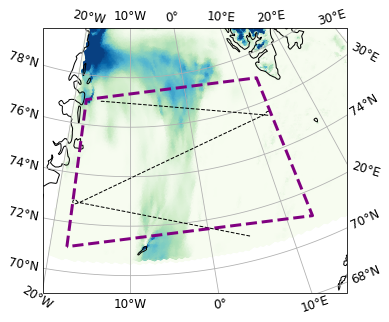

In [16]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
precip_map=plt.figure(figsize=(12,12))

if flight[0]=="RF05":
        central_lat=70
        central_lon=-10
elif flight[0]=="RF06":
        central_lat=74
        central_lon=15

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(
                                central_longitude=central_lon,
                                central_latitude=central_lat))
    # IVT convergence as background based on ERA5
C1=ax1.scatter(np.rad2deg(hydro_ds["clon"]),
            np.rad2deg(hydro_ds.clat),c=hydro_ds["hourly_prec"][0,:],
            cmap="GnBu",s=0.5,vmin=0.0,vmax=1,
            transform=ccrs.PlateCarree())
ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=3,ls="--",color="purple",
          transform=ccrs.PlateCarree(),zorder=3)
  
ax1.coastlines(resolution="50m")
gl1=ax1.gridlines(draw_labels=True,dms=True,
                          x_inline=False,y_inline=False)
    
ax1.plot(processed_radar["lon"],processed_radar["lat"],color="k",ls="--",lw=1,transform=ccrs.PlateCarree())
ax1.set_extent([halo_df["longitude"].min()-2,halo_df["longitude"].max()+2,
                halo_df["latitude"].min()-2,halo_df["latitude"].max()+2])

In [17]:
temp_clat=np.rad2deg(pd.Series(hydro_ds.clat))
cutted_clat=temp_clat[temp_clat.between(halo_df["latitude"].min(),halo_df["latitude"].max())]
temp_clon=np.rad2deg(pd.Series(hydro_ds.clon))
temp_clon=temp_clon.loc[cutted_clat.index]
cutted_clon=temp_clon[temp_clon.between(halo_df["longitude"].min(),halo_df["longitude"].max())]
cutted_icon_precip=hydro_ds["hourly_prec"].isel(
                                ncells=cutted_clon.index)
#hydro_ds["hourly_prec"]
precip_icon_series=pd.DataFrame(data=np.array(cutted_icon_precip.values[0,:]))

In [18]:
radar_precip_rate=pd.DataFrame(data=np.nan,index=precipitation_rate.index,
                               columns=["mean_snow","mean_rain","rate"])
radar_precip_rate["mean_snow"]=precipitation_rate["mean_snow"]
radar_precip_rate["mean_rain"]=precipitation_rate["mean_rain"]
radar_precip_rate=radar_precip_rate.fillna(0)
radar_precip_rate["rate"]=radar_precip_rate["mean_snow"]+radar_precip_rate["mean_rain"]

Figure saved as  C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Rain_rate_representativeness.png


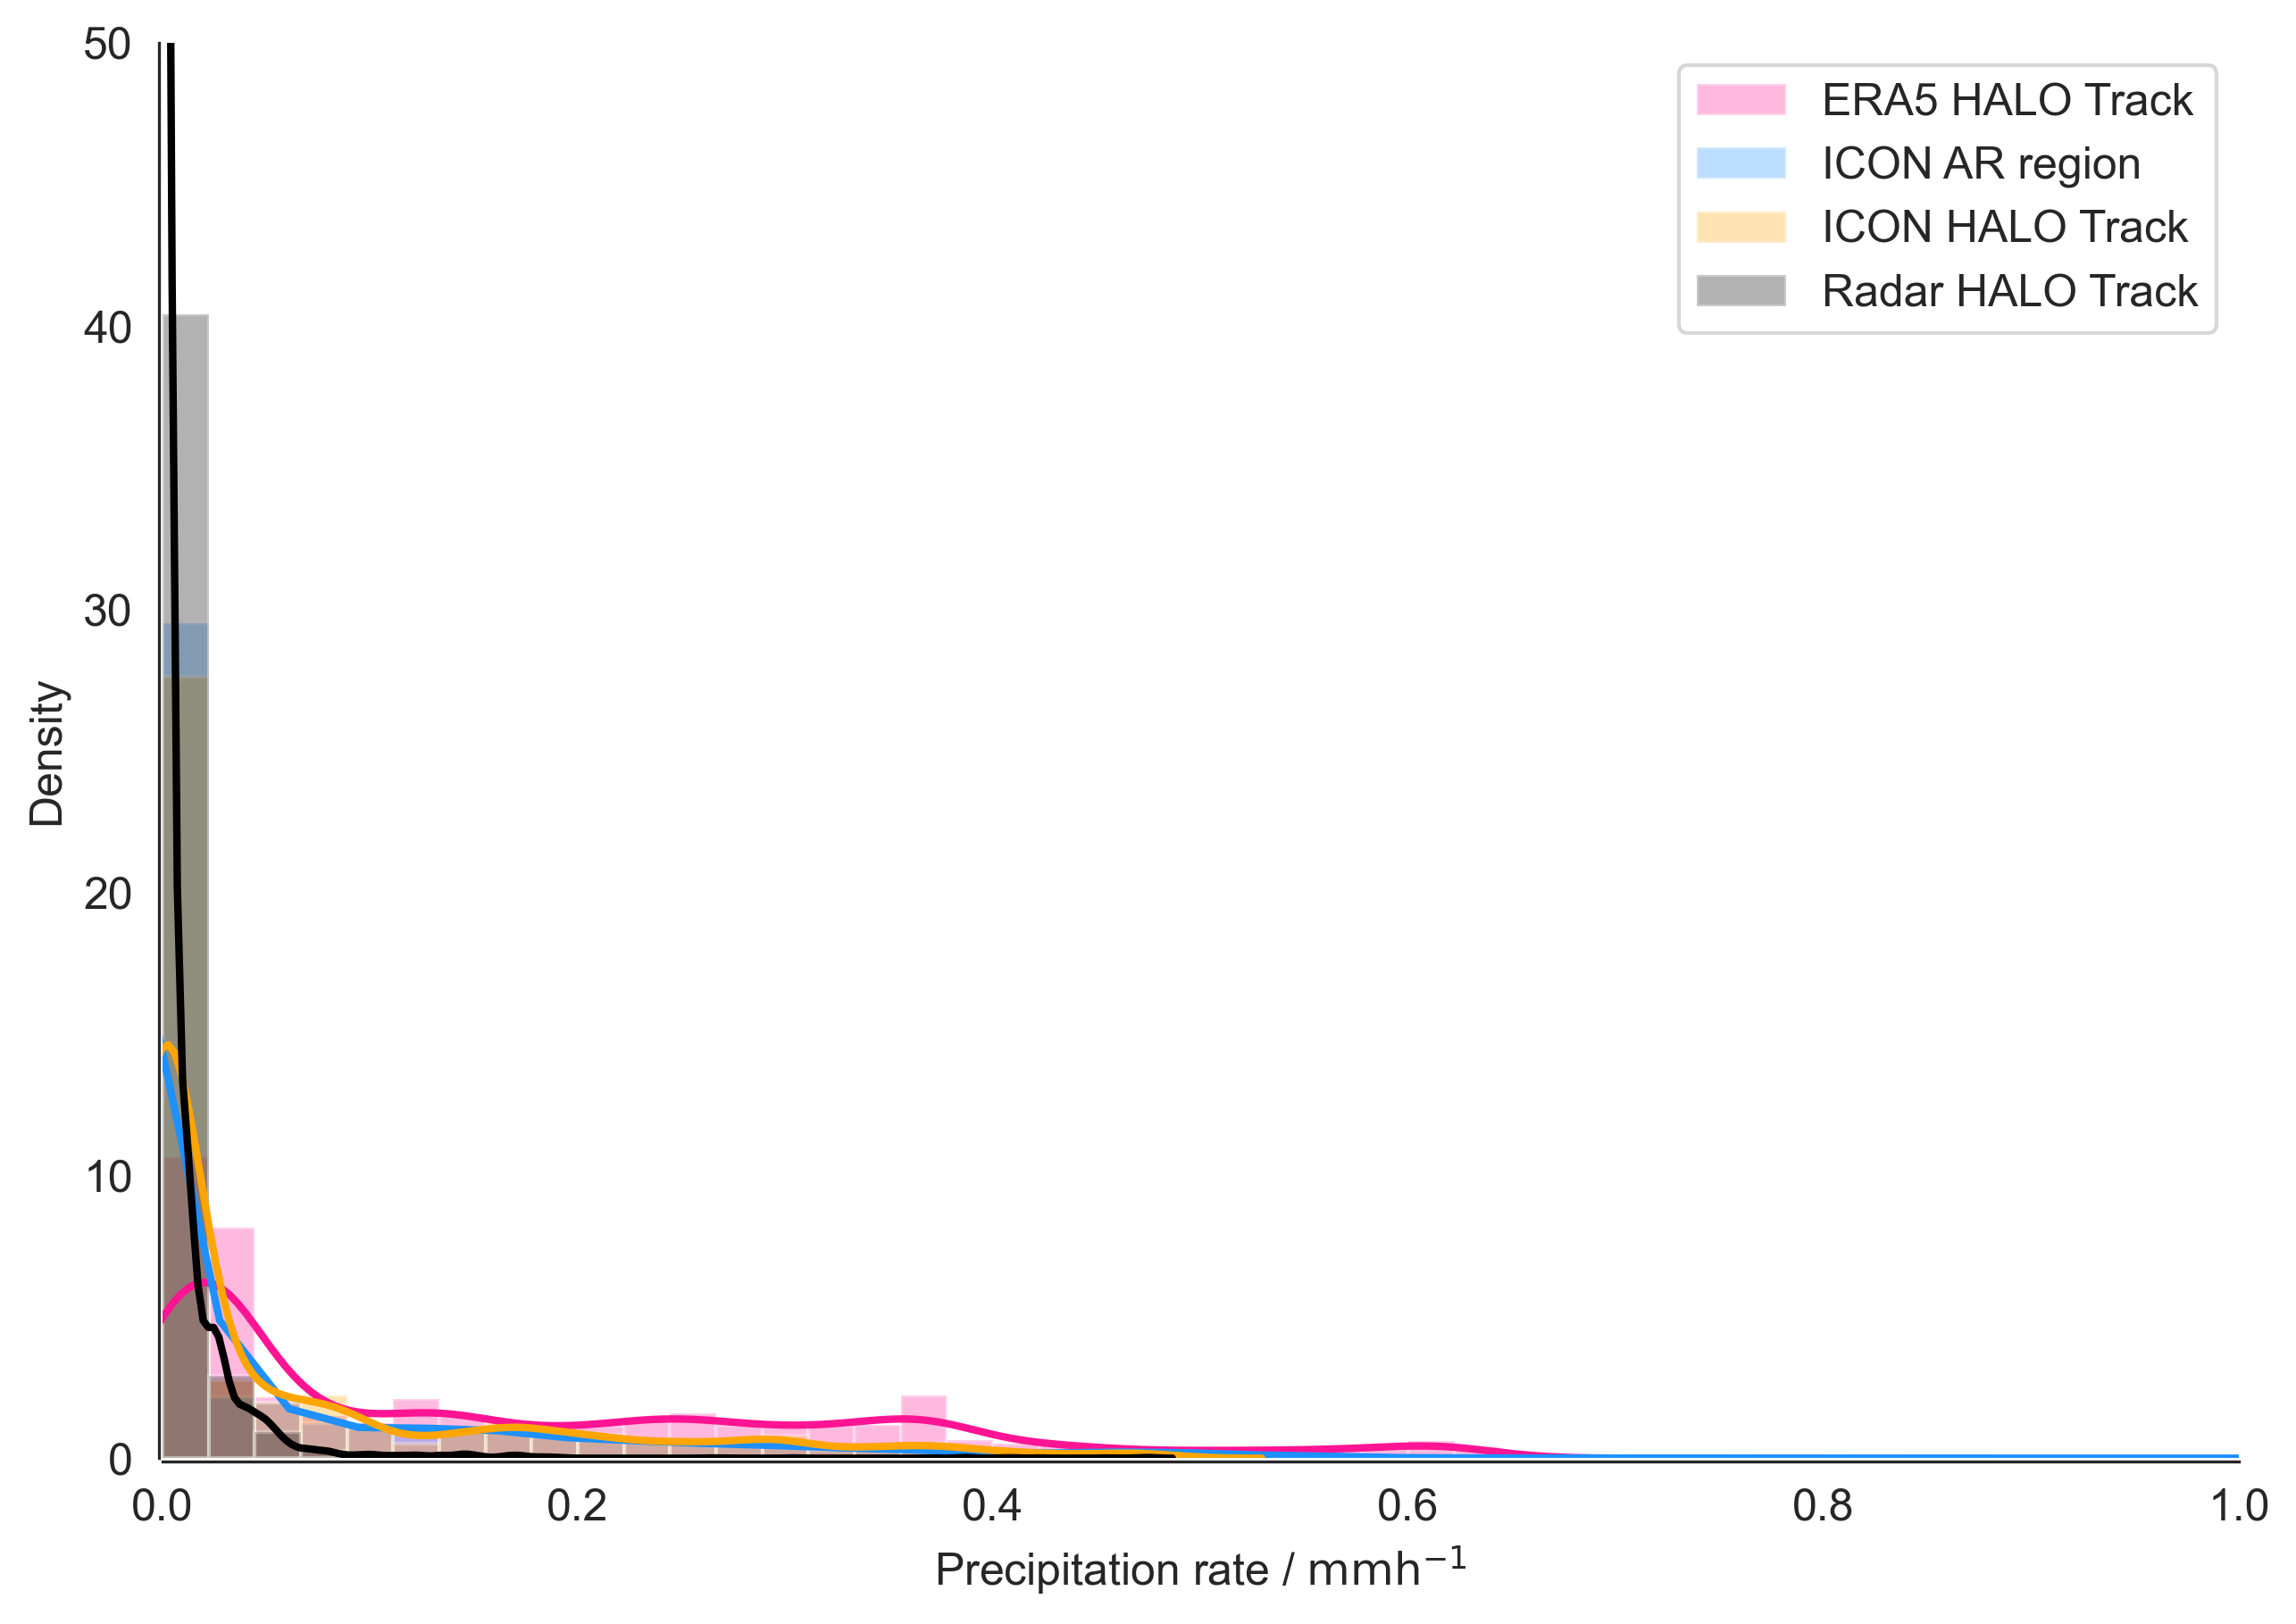

In [19]:
import seaborn as sns
sns.set_style("white")

x1 = precip_icon_series.copy()
x2 = halo_icon_hmp["Interp_Precip"]
x3 = halo_era5["Interp_Precip"]
x4 = radar_precip_rate["rate"]
# Plot
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 300)#
sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)
sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region", **kwargs)
sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", **kwargs)
sns.distplot(x4, bins=np.linspace(0,2,91),color="k", label="Radar HALO Track", **kwargs)
plt.ylim(0,50)
plt.xlim(0,1)
plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
plt.legend()
fig_name="Rain_rate_representativeness.png"
fig_path=plot_path
sns.despine(offset=1)
plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as ",fig_path+fig_name)

Create boxplot
Create dist plot
Figure saved as  C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Conditional_Rain_rate_representativeness.png


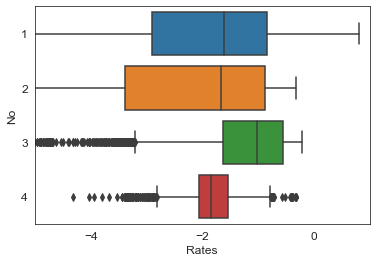

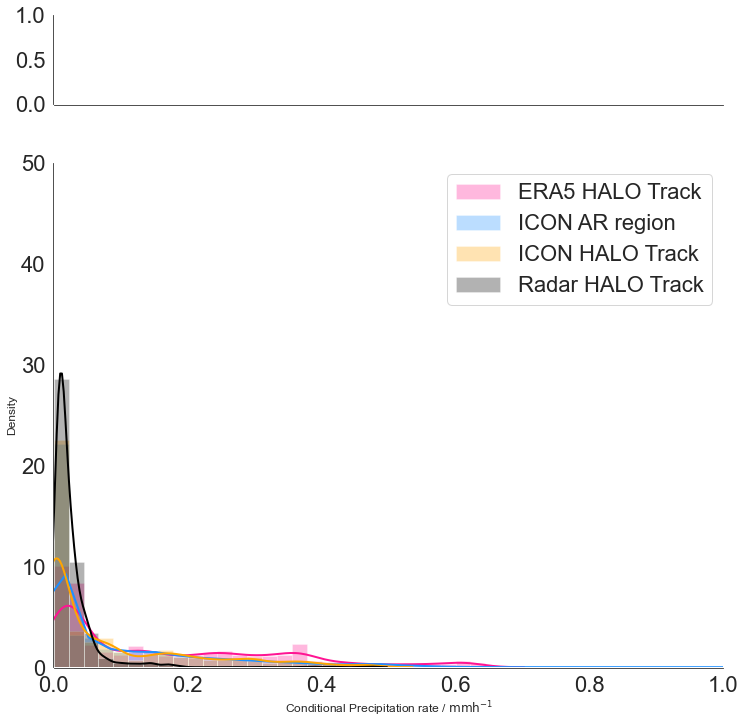

In [20]:
###############################################################################################
x1 = precip_icon_series.copy()
x1 = x1[x1>0]
x1 = x1.dropna()
x1.index=range(len(x1))
x2 = halo_icon_hmp["Interp_Precip"]
x2 = x2[x2>0]
x2.index=range(len(x2))
x3 = halo_era5["Interp_Precip"]
x3 = x3[x3>0]
x3.index = range(len(x3))
x4 = radar_precip_rate["rate"]
x4 = x4[x4>0]
x4.index = range(len(x4))

x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],
                       index=x1.index)
x_appended["Rates"]=x1.values.astype(float)
x_appended["Data"] ="ICON_AR_Region"
x_appended["No"]   = 1

x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x2.index)
x2_append["Rates"]=x2.values
x2_append["Data"] ="ICON_HALO_Track"
x2_append["No"]  =2

x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x3.index)
x3_append["Rates"]=x3.values
x3_append["Data"] ="ERA5_HALO_Track"
x3_append["No"]   =3

x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x4.index)
x4_append["Rates"]=x4.values
x4_append["Data"] ="Radar_HALO_Track"
x4_append["No"]   =4

x_appended=x_appended.append(x2_append,ignore_index=True)
x_appended=x_appended.append(x3_append,ignore_index=True)
x_appended=x_appended.append(x4_append,ignore_index=True)
x_to_plot=x_appended.copy()#iloc[0:1000,:]
del x_to_plot["Data"]
print("Create boxplot")
boxpl=sns.boxplot(x=np.log10(x_to_plot["Rates"]),
            y=x_to_plot["No"],
            orient="h")
boxpl.set_xlim([-5,1])
print("Create dist plot")
################################################################################################
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,12))

import seaborn as sns
sns.set_style("white")
import matplotlib
matplotlib.rcParams.update({"font.size":22})
# Plot
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})


sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track",ax=ax_hist, **kwargs)
sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region",ax=ax_hist, **kwargs)
sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", ax=ax_hist, **kwargs)
sns.distplot(x4, bins=np.linspace(0,2,91),color="k", label="Radar HALO Track", ax=ax_hist,**kwargs)
plt.ylim(0,50)
plt.xlim(0,1)
plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
plt.legend()
fig_name="Conditional_Rain_rate_representativeness.png"
fig_path=plot_path
sns.despine(offset=1)
plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as ",fig_path+fig_name)

### 3D Flight Overview

#### Prepare sondes

In [21]:
#Dropsondes["alt"]

In [22]:
take_arbitary=False
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)

sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
relevant_sondes_dict={}

if take_arbitary:
    for sector in ["warm_sector","core","cold_sector","internal"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_internal_sondes=[7,8,13,14]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]


Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_Budget_Area.png


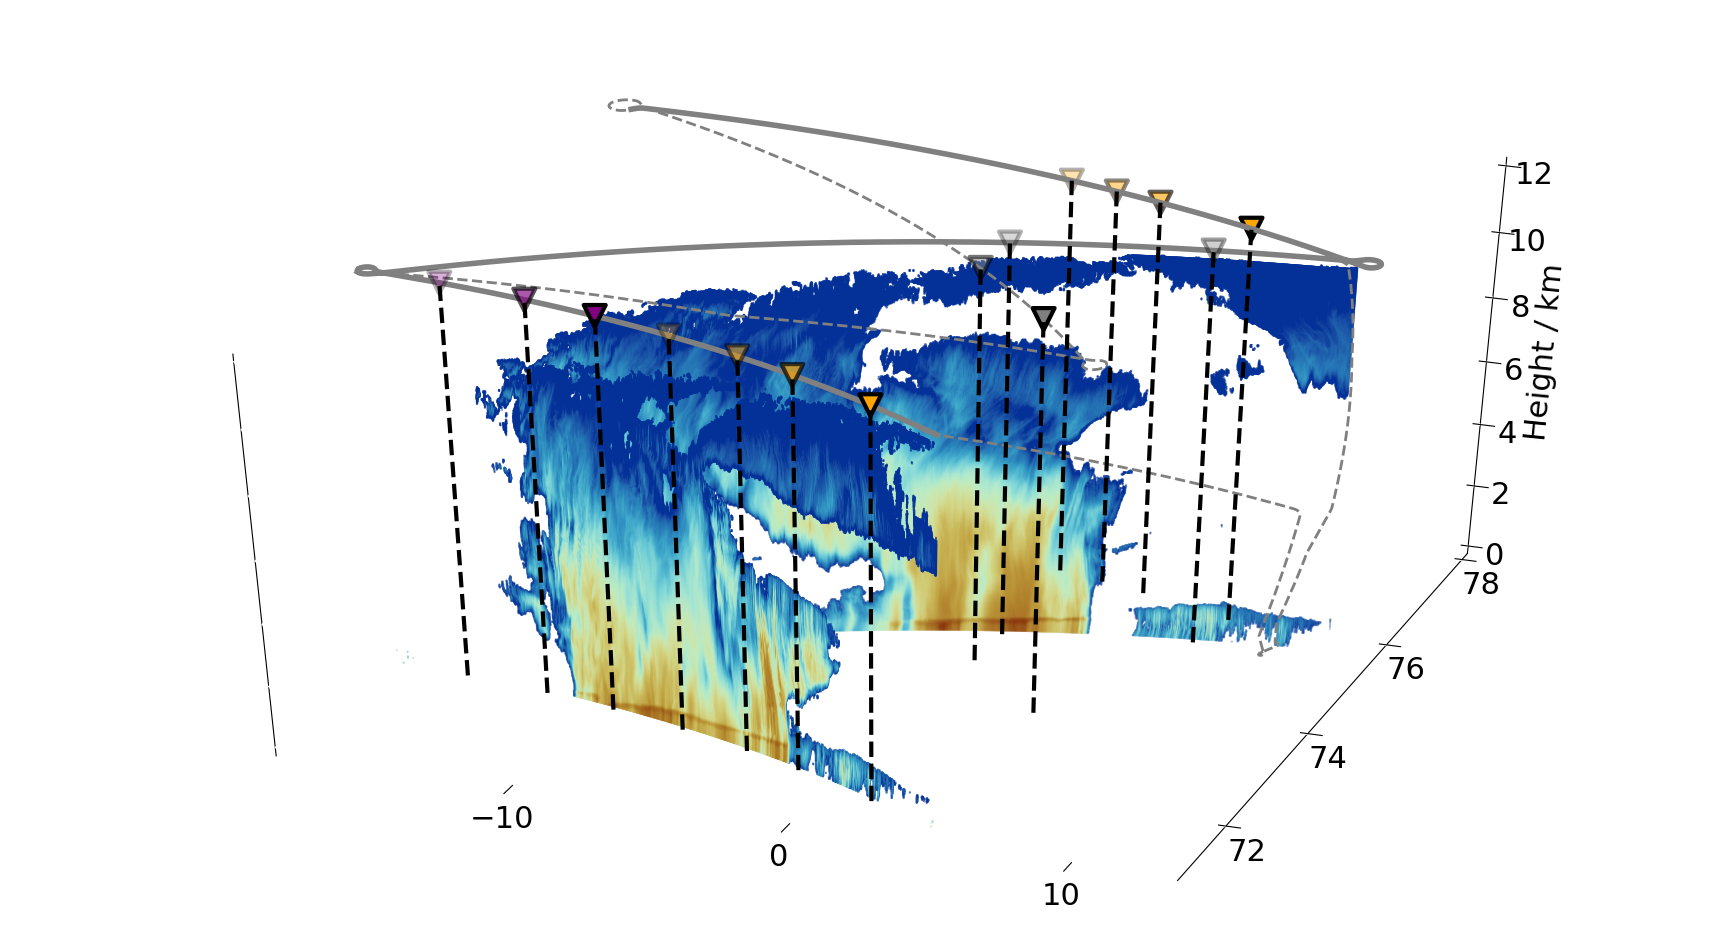

In [28]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib.collections import LineCollection
#from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from cmcrameri import cm as cmaeri

import matplotlib.pyplot as plt
import numpy as np


import itertools
import cartopy.feature
from cartopy.mpl.patch import geos_to_path

matplotlib.rcParams.update({"font.size":22})
take_all=False
if take_all:
    curved_radar=processed_radar.copy()#sel({"time":slice(time_start,time_end)})
else:
    time_start=pd.Timestamp(internal_times[0])-pd.Timedelta("15min")
    time_end  =pd.Timestamp(internal_times[0])+pd.Timedelta("15min")
    curved_radar=processed_radar.sel({"time":slice(time_start,time_end)})

# Radar period

#time_start=pd.Timestamp(inflow_times[0])#-pd.Timedelta("10min")
#time_end  =pd.Timestamp(outflow_times[-1])#+pd.Timedelta("10min")
curved_radar=pd.DataFrame(data=np.array(processed_radar["dBZg"][:]),
                          index=pd.DatetimeIndex(np.array(processed_radar["dBZg"].time[:])),
                          columns=np.array(processed_radar["height"][:]))

curved_radar = curved_radar[~curved_radar.index.duplicated(keep='first')]
# This import registers the 3D projection, but is otherwise unused.
x, y, z = processed_radar["lon"], processed_radar["lat"], processed_radar["alt"]
x_contour=np.tile(x,(len(processed_radar["height"]),1)).T
y_contour=np.tile(y,(len(processed_radar["height"]),1)).T

z_contour_1d=np.array(processed_radar["height"][:])
z_contour=np.tile(z_contour_1d,(len(processed_radar["time"]),1))
# Set up plot
inflow_st_ind=curved_radar.index.get_loc(inflow_times[0]).start
inflow_end_ind=curved_radar.index.get_loc(inflow_times[-1]).start
internal_st_ind=curved_radar.index.get_loc(internal_times[0]).start
internal_end_ind=curved_radar.index.get_loc(internal_times[-1]).start
outflow_st_ind=curved_radar.index.get_loc(outflow_times[0]).start
outflow_end_ind=curved_radar.index.get_loc(outflow_times[-1]).start


fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(22,12))

#ax = plt.axes(projection="3d", xlim=[curved_radar["lon"].values.min()-1,
#                                     curved_radar["lon"].values.max()+1],
#            ylim=[curved_radar["lat"].values.min()-1,curved_radar["lat"].values.max()+1],
#            zlim=[0, 12])

#target_projection = ccrs.PlateCarree()
#feature = cartopy.feature.NaturalEarthFeature("physical", "coastline", "50m")
#geoms = feature.geometries()#

#geoms = [target_projection.project_geometry(geom, feature.crs)
#         for geom in geoms]

#paths = list(itertools.chain.from_iterable(geos_to_path(geom) for geom in geoms))

# At this point, we start working around mpl3d's slightly broken interfaces.
# So we produce a LineCollection rather than a PathCollection.
#segments = []
#for path in paths:
#    vertices = [vertex for vertex, _ in path.iter_segments()]
#    vertices = np.asarray(vertices)
#    segments.append(vertices)

#lc = LineCollection(segments, color="black", zorder=0)

#ax.add_collection3d(lc)

# Plot dropsonde profiles
sector_colors={"warm_sector":"orange",
              "cold_sector":"purple",
              "internal":"grey"}

                                               #sonde=pd.DataFrame(data=np.nan,columns=["alt","lat","lon"])
ax.scatter(x_contour[inflow_st_ind:inflow_end_ind,:].flatten(),y_contour[inflow_st_ind:inflow_end_ind,:].flatten(),
           z_contour[inflow_st_ind:inflow_end_ind,:].flatten()/1000,s=0.1,
          c=np.array(curved_radar.iloc[inflow_st_ind:inflow_end_ind,:].values[:]),cmap=cmaeri.roma_r,vmin=-30,vmax=30,
          zorder=2)
ax.scatter(x_contour[internal_st_ind:internal_end_ind,:].flatten(),y_contour[internal_st_ind:internal_end_ind,:].flatten(),
           z_contour[internal_st_ind:internal_end_ind,:].flatten()/1000,s=0.1,
          c=np.array(curved_radar.iloc[internal_st_ind:internal_end_ind,:].values[:]),cmap=cmaeri.roma_r,vmin=-30,vmax=30,
           zorder=1)

#ax.scatter(x_contour[outflow_st_ind:outflow_end_ind,:].flatten(),y_contour[outflow_st_ind:outflow_end_ind,:].flatten(),
#           z_contour[outflow_st_ind:outflow_end_ind,:].flatten()/1000,s=0.1,
#          c=np.array(curved_radar.iloc[outflow_st_ind:outflow_end_ind,:].values[:]),cmap=cmaeri.roma_r,vmin=-30,vmax=30,
#           zorder=0)
ax.plot(radar_ds["lon"],radar_ds["lat"],z.mean()/1000,color="grey",linewidth=2,ls="--",zorder=4)
ax.plot(x, y, z.mean()/1000,linewidth=4,color="grey",zorder=4)
for sector in ["warm_sector","cold_sector","internal"]:
    if not sector=="internal":
        for in_out in ["in","out"]:
            sonde_no=relevant_sondes_dict[sector][in_out]
            ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                    Dropsondes["Lat"].iloc[sonde_no],
                    z.mean()/1000,#np.array(Dropsondes["alt"][Dropsondes["alt"].keys()[sonde_no].values[:]),
                    color=sector_colors[sector],marker="v",
                      s=250,edgecolor="k",lw=3,zorder=10)
            ax.plot([Dropsondes["Lon"].iloc[sonde_no],Dropsondes["Lon"].iloc[sonde_no]],
               [Dropsondes["Lat"].iloc[sonde_no],Dropsondes["Lat"].iloc[sonde_no]],
               [0,z.mean()/1000],ls="--",color="k",lw=3,zorder=10)
    else:
        sonde_no=relevant_sondes_dict[sector],
        ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                Dropsondes["Lat"].iloc[sonde_no],
                z.mean()/1000,#np.array(Dropsondes["alt"][Dropsondes["alt"].keys()[sonde_no].values[:]),
                color=sector_colors[sector],marker="v",
                s=250,edgecolor="k",lw=3,zorder=10)
        ax.plot([Dropsondes["Lon"].iloc[sonde_no],Dropsondes["Lon"].iloc[sonde_no]],
               [Dropsondes["Lat"].iloc[sonde_no],Dropsondes["Lat"].iloc[sonde_no]],
               [0,z.mean()/1000],ls="--",color="k",lw=3,zorder=10)        #ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
            #        Dropsondes["Lat"].iloc[sonde_no],
            #        12,#np.array(Dropsondes["alt"][Dropsondes["alt"].keys()[sonde_no].values[:]),
            #        color=sector_colors[sector],marker="v",
            #          s=250,edgecolor="k",lw=3,zorder=10)

# Set view angle
ax.xaxis._axinfo['juggled'] = (1,2,0)
ax.view_init(40,290)
ax.set_zlim([0,12])
ax.set_xlim([processed_radar["lon"].values.min(),
             processed_radar["lon"].values.max()])
ax.set_ylim([processed_radar["lat"].values.min(),processed_radar["lat"].values.max()])
# changing grid lines thickness of x axis to 1
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
#ax.xaxis.pane.set_edgecolor('#D0D0D0')
#ax.yaxis.pane.set_edgecolor('#D0D0D0')
#ax.zaxis.pane.set_edgecolor('#D0D0D0')
#ax.xaxis.pane.set_alpha(1)
#ax.yaxis.pane.set_alpha(1)
#ax.zaxis.pane.set_alpha(1)
ax.set_yticks([72,74,76,78])
ax.set_xticks([-10,0,10])
ax.xaxis._axinfo["grid"].update({"linewidth":1,"color":"w"})
ax.yaxis._axinfo["grid"].update({"linewidth":2,"color":"w"})
ax.zaxis._axinfo["grid"].update({"linewidth":2,"color":"w"})
ax.xaxis.set_tick_params({"width":10})
ax.yaxis.set_tick_params({"width":10})
ax.zaxis.set_tick_params({"width":10})
# changing grid lines thickness of Y axis to 1 and giving color to red
#ax.set_xlabel("Longitude / deg",linespacing=10)
#ax.set_ylabel("Latitude / deg N",linespacing=6.5)
ax.set_zlabel("Height / km",linespacing=3.1)
#sns.despine(offset=10,ax=ax)
#ax = plt.axes(projection="3d", 
#              xlim=[curved_radar["lon"].values.min()-5,
#                    curved_radar["lon"].values.max()+5],
#              ylim=[curved_radar["lat"].values.min()-5,
#                    curved_radar["lat"].values.max()+5],
#              zlim=[0, 12])

#ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(
#                                central_longitude=central_lon,
#                                central_latitude=central_lat))
    # IVT convergence as background based on ERA5
#C1=ax1.scatter(np.rad2deg(hydro_ds["clon"]),
#            np.rad2deg(hydro_ds.clat),c=hydro_ds["hourly_prec"][0,:],
#            cmap="GnBu",s=0.5,vmin=0.0,vmax=1,
#            transform=ccrs.PlateCarree())
#ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
#          halo_df["longitude"].max(),halo_df["longitude"].max(),
#          halo_df["longitude"].min()],
#          [halo_df["latitude"].min(),halo_df["latitude"].max(),
#          halo_df["latitude"].max(),halo_df["latitude"].min(),
#          halo_df["latitude"].min()],
#          lw=3,ls="--",color="purple",
#          transform=ccrs.PlateCarree(),zorder=3)
  
#ax.coastlines(resolution="50m")
#gl1=ax1.gridlines(draw_labels=True,dms=True,
#                          x_inline=False,y_inline=False)
#ax1.plot(processed_radar["lon"],processed_radar["lat"],color="k",ls="--",lw=1,transform=ccrs.PlateCarree())
#ax1.set_extent([halo_df["longitude"].min()-5,halo_df["longitude"].max()+5,
#                halo_df["latitude"].min()-5,halo_df["latitude"].max()+5])
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
#rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
#ax.set_zlim([0,12])
fig_name="RF05_Budget_Area.png"
fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as:",plot_path+fig_name)
#plt.show()

Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_IWV_IVT_Track_Map.png


SystemExit: 

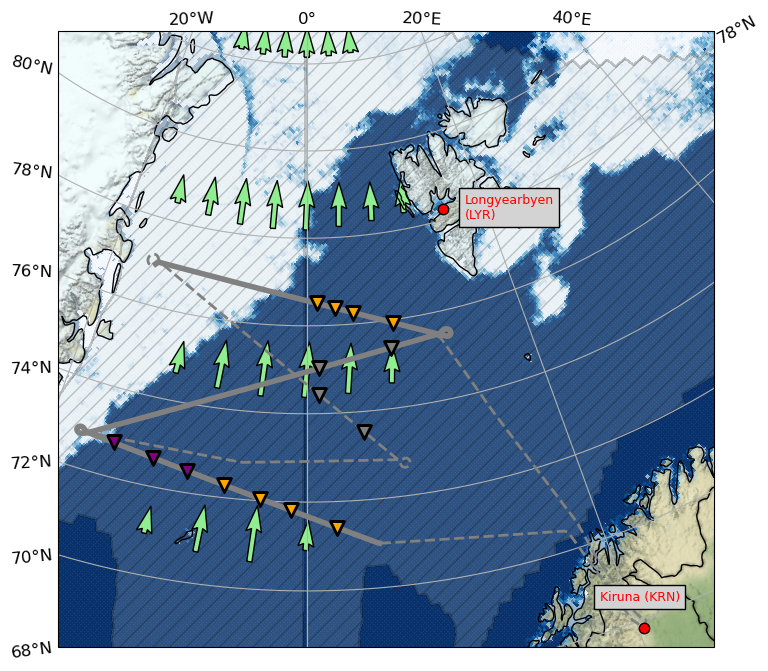

In [31]:
#def plot_flight_map_with_sea_ice_conc(HALO_Devices_cls,bahamas_dict,
#                                      cfg_dict,date,plot_path):
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

matplotlib.rcParams.update({"font.size":16})
orig_map = plt.cm.get_cmap('Blues') # getting the original colormap using cm.get_cmap() function
reversed_map = orig_map.reversed()  # reversing the original colormap using reversed() function
                                        # normally the actual bahamas file is used from HALO-(AC)3. However,
                                        # this is not feasible now for testing
    
add_quiver=True
sea_ice_file=cfg_dict["device_data_path"]+"sea_ice/"+\
                    "asi-AMSR2-n6250-"+cfg_dict["date"]+"-v5.4.nc"
    
seaice = xr.open_dataset(sea_ice_file)
seaice = seaice.seaice
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
    
    
llcrnlat = 68
llcrnlon = -10
urcrnlat = 82
urcrnlon = 20
        
extent = [llcrnlon-5, urcrnlon+5, llcrnlat, urcrnlat]
coordinates=dict(EDMO=(11.28, 48.08), 
                     Keflavik=(-22.6307, 63.976),
                     Kiruna=(20.336, 67.821),
                     Bergen=(5.218, 60.293),
                     Longyearbyen=(15.46, 78.25),
                     Lerwick=(-1.18, 60.13),
                     Ittoqqortoormiit=(-21.95, 70.48),
                     Tasiilaq=(-37.63, 65.60))
# set plotting options
plt.rcdefaults()
# get plot properties
props = dict(Flight_20210705b=dict(figsize=(4, 4),
                    cb_loc="bottom", shrink=1, l_loc=1))
matplotlib.rcParams.update({"font.size":12})
# start plotting
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection": ccrs.NorthPolarStereo()})
ax.add_image(stamen_terrain, 4)
ax.coastlines(resolution="50m")
ax.add_feature(cartopy.feature.BORDERS)
ax.set_extent(extent, crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels  = False
# add sea ice extent
ax.pcolormesh(seaice.lon, seaice.lat,seaice, 
                      transform=ccrs.PlateCarree(), cmap=reversed_map,
                      alpha=0.9)

x1,y1 = coordinates["Kiruna"]   
x2, y2 =coordinates["Longyearbyen"]
ax.plot(x1, y1, '.r', markersize=15, markeredgecolor="k",
        transform=ccrs.PlateCarree(),zorder=10)

ax.plot(x2, y2, '.r', markersize=15, markeredgecolor="k",
        transform=ccrs.PlateCarree(),zorder=10)

ax.text(x2 + 2, y2 - 0.35, "Longyearbyen\n(LYR)", fontsize=9,
         transform=ccrs.PlateCarree(),color="red",
         bbox=dict(facecolor='lightgrey',edgecolor="black"),zorder=12)
ax.text(x1 - 2, y1 + 0.9, "Kiruna (KRN)", fontsize=9,
         transform=ccrs.PlateCarree(),color="red",
         bbox=dict(facecolor='lightgrey',edgecolor="black"),zorder=12)

ax.plot(radar_ds["lon"],radar_ds["lat"],z.mean()/1000,color="grey",linewidth=2,ls="--",zorder=4,
       transform=ccrs.PlateCarree())
ax.plot(x, y, z.mean()/1000,linewidth=4,color="grey",zorder=4,
       transform=ccrs.PlateCarree())


## Show ERA5-AR
#if show_AR_detection:    
import atmospheric_rivers as AR
AR=AR.Atmospheric_Rivers("ERA",use_era5=True)
flight_date="20220315"
AR_era_ds=AR.open_AR_catalogue(after_2019=int(flight_date[0:4])>2019,
        year=cmpgn_cls.year,month=cmpgn_cls.flight_month[flight[0]])
AR_era_data=AR.specify_AR_data(AR_era_ds,flight_date)
i=12 # hour time step to consider
hatches=plt.contourf(AR_era_ds.lon,AR_era_ds.lat,
            AR_era_ds.shape[0,AR_era_data["model_runs"].start+i,0,:,:],
            hatches=["//"],cmap="bone_r",alpha=0.2,
            transform=ccrs.PlateCarree())
for c,collection in enumerate(hatches.collections):
    collection.set_edgecolor("k")

##### Quivers for IVT magnitude and direction
#-----------------------------------------------------------------#
# Quiver-Plot
if add_quiver:
    step=15
    quiver_lon=np.array(ds["longitude"][::step])
    quiver_lat=np.array(ds["latitude"][::step])
    u=ds["IVT_u"][i,::step,::step]
    v=ds["IVT_v"][i,::step,::step]
    v=v.where(v>200)
    v=np.array(v)
    u=np.array(u)
    quiver=plt.quiver(quiver_lon,quiver_lat,
                u,v,color="lightgreen",edgecolor="k",lw=1,
                                  scale=800,scale_units="inches",
                                  pivot="mid",width=0.008,
                                  transform=ccrs.PlateCarree())
    plt.rcParams.update({'hatch.color': 'lightgreen'})
#-----------------------------------------------------------------#            

for sector in ["warm_sector","cold_sector","internal"]:
    if not sector=="internal":
        for in_out in ["in","out"]:
            sonde_no=relevant_sondes_dict[sector][in_out]
            ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                    Dropsondes["Lat"].iloc[sonde_no],
                    color=sector_colors[sector],marker="v",
                      s=100,edgecolor="k",transform=ccrs.PlateCarree(),lw=2,zorder=10)
    else:
        sonde_no=relevant_sondes_dict[sector],
        ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                Dropsondes["Lat"].iloc[sonde_no],
                color=sector_colors[sector],marker="v",
                s=100,edgecolor="k",lw=2,zorder=10,transform=ccrs.PlateCarree())

    
        
y_pos=0.85
sonde_shapes=["v","s"]
fig_name=flight[0]+"_AR_IWV_IVT_Track_Map.png"
fig.savefig(plot_path+fig_name,bbox_inches="tight",dpi=600)
print("Figure saved as:",plot_path+fig_name)

sys.exit()
"""
HALO_Devices_cls=Measurement_Instruments_QL.HALO_Devices(prcs_cfg_dict)    
Sondes_cls=Measurement_Instruments_QL.Dropsondes(HALO_Devices_cls)
    Sondes_cls.calc_integral_variables(integral_var_list=["IWV","IVT"])
    sonde_data=Sondes_cls.sonde_dict
    bahamas=bahamas_dict[flight]
    # select position and time data
    lon, lat, altitude, times = bahamas["IRS_LON"], \
                                        bahamas["IRS_LAT"],\
                                            bahamas["IRS_ALT"],\
                                                bahamas["TIME"]
    # calculate flight duration
    flight_duration = pd.Timedelta((times[-1] - \
                                        times[0]).values).to_pytimedelta()
    
    
            
    # plot flight track and color by relative humidity
    points = ax.plot(lon, lat, color="darkorange",
                        lw=1.5, transform=ccrs.PlateCarree(),label=flight)
    for sonde in sonde_data["launch_time"].keys():
        release_lat=sonde_data["reference_lat"][sonde].data[0]
        release_lon=sonde_data["reference_lon"][sonde].data[0]
        scat=ax.scatter(release_lon,release_lat,marker=sonde_shapes[1],
                       s=300,edgecolors="k",c=sonde_data["IVT"].loc[sonde],
                       cmap="BuGn",vmin=0, vmax=300,
                       transform=ccrs.PlateCarree(), zorder=3)
        scat2=ax.scatter(release_lon,release_lat,marker=sonde_shapes[0],
                       s=100,edgecolors="k",c=sonde_data["IWV"].loc[sonde],
                       cmap="BuPu",vmin=0, vmax=20,
                       transform=ccrs.PlateCarree(), zorder=4)
    
    cbar1= fig.colorbar(scat,extend="max",shrink=0.8)
    cbar1.set_label("IVT ($\mathrm{kg}\mathrm{m}^{-1}\mathrm{s}^{-1}$)")
    cbar = fig.colorbar(scat2,extend="max",shrink=0.8)
    cbar.set_label("IWV ($\mathrm{kg}\mathrm{m}^{-2}$)")
    # add the corresponding colorbar and decide whether to plot it horizontally or vertically
    #plt.colorbar(points, ax=ax, pad=0,label="Relative Humidity (%)", 
    #         orientation="horizontal",shrink=0.835)
    # write the flight duration in the lower left corner of the map
    y_pos=y_pos+0.04
    ax.text(0.05,y_pos , f"Duration: {str(flight_duration)[:4]} (hr:min)",
                transform=ax.transAxes, fontsize=10, 
                color="darkorange",bbox=dict(facecolor='lightgrey',
                                                    edgecolor="black"))
    ax.legend(loc="upper right",facecolor="lightgrey",edgecolor="black")
    plot_path
"""